# cosine schedule

- Use a cosine schedule
- Take advantage of the fact that it's a closed form expression to just work out the inverse
- Do away with the need to define a `T` for `t/T` and just define `t` between [0, 1)

In [ ]:
!pip install k-diffusion

In [5]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [6]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [18]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [8]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

Generating test split: 100%|██████████| 10000/10000 [00:01<00:00, 5722.76 examples/s]


In [9]:
def abar(t): return (t * math.pi / 2).cos()**2
def inv_abar(x): return x.sqrt().acos() * 2 / math.pi

In [14]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0, 0.999) # this doesn't need the clamp, but do it to agree with the original
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt() * x0 + (1 - abar_t).sqrt() * ε
    return (xt, t.to(device)), ε

In [15]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=fc.defaults.cpus)

In [16]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt,t),eps = b = next(iter(dl))
                  

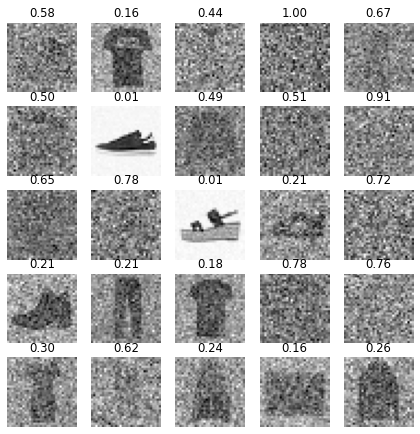

In [19]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

In [20]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [21]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [22]:
lr = 4e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dl)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.397,0,train
0.072,0,eval
0.058,1,train
0.055,1,eval
0.049,2,train
0.047,2,eval
0.045,3,train
0.054,3,eval
0.044,4,train
0.042,4,eval


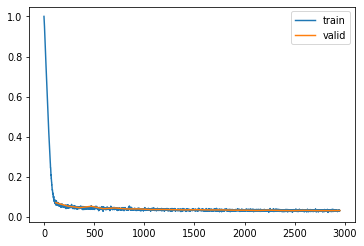

In [23]:
learn.fit(epochs)

In [25]:
torch.save(learn.model, '../models/fashion_cos.pkl')
# torch.load('../models/fashion_cos.pkl', map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

In [35]:
def denoise(x_t, noise, t):
    device = x_t.device
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    return ((x_t - (1 - abar_t).sqrt() * noise) / abar_t.sqrt()).clamp(-1, 1)

In [30]:
with torch.no_grad(): noise = learn.model((xt.to(def_device), t.to(def_device)))

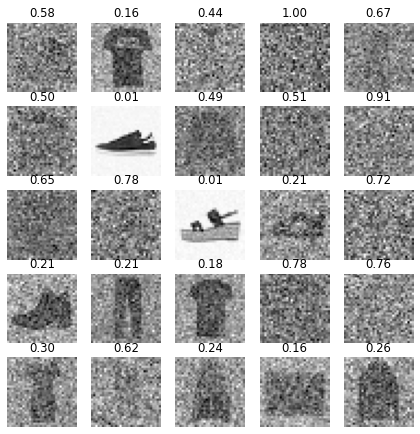

In [31]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

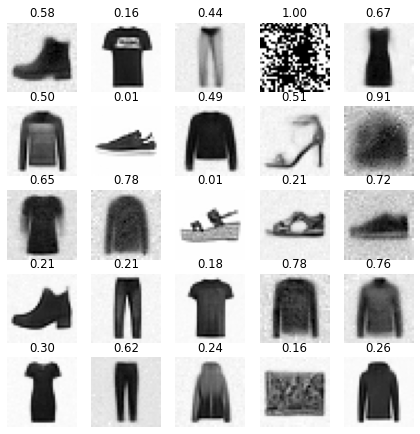

In [36]:
show_images(denoise(xt.to(def_device), noise, t.to(def_device))[:25].clamp(-1, 1), imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

## Sampling

In [38]:
from miniai.fid import ImageEval

In [45]:
cmodel = torch.load('../models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) * 2 - 1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb, yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

larger size batch needed to get an accurate FID, KID

In [48]:
sz = (256, 1, 32, 32)

In [58]:
sz = (2048, 1, 32, 32)

In [53]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1 / bbar_t).sqrt() * (1 - abar_t / abar_t1).sqrt()) * eta
    x_0_hat = ((x_t - (1 - abar_t).sqrt() * noise) / abar_t.sqrt()).clamp(-1.5, 1.5)
    if bbar_t1 <= sig**2 + 0.01: sig = 0 # set to 0 if very small or NaN
    x_t = abar_t1.sqrt() * x_0_hat + (bbar_t1 - sig**2).sqrt() * noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat, x_t

In [54]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(1 - 1 / steps, 0, steps)
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i, t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t - 1 / steps) if t >= 1 / steps else torch.tensor(1)
        x_0_hat, x_t = f(x_t, noise, abar_t, abar_t1, 1 - abar_t, 1 - abar_t1, eta, 1 - ((i+1) / 100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [59]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1] * 2)
s.min() , s.max(), s.shape

(tensor(-1.1396), tensor(1.6392), torch.Size([2048, 1, 32, 32]))

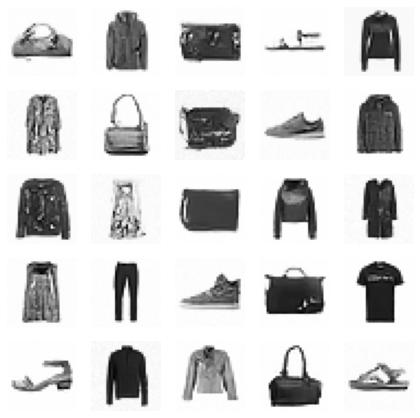

In [60]:
show_images(s[:25], imsize=1.5)

In [61]:
ie.fid(s), ie.kid(s), s.shape

(3.021240234375, 0.04920748993754387, torch.Size([2048, 1, 32, 32]))

In [62]:
preds = sample(ddim_step, model, sz, steps=50, eta=1.)
ie.fid(preds[-1]*2)

5.2850341796875